In [ ]:
# !pip list

In [ ]:
!pip install requests
!pip install pandas
!pip install plotly

In [2]:
import requests

API_KEY = 'QV8D-PY9K-9LMT-DWEI'

url = f"https://api.bart.gov/api/sched.aspx?cmd=arrive&orig=ASHB&dest=CIVC&date=now&key={API_KEY}&b=2&a=2&l=1&json=y"

print(url)

response = requests.get(url)

print(f"Status Code: {response.status_code}")

json_data = response.json()




https://api.bart.gov/api/sched.aspx?cmd=arrive&orig=ASHB&dest=CIVC&date=now&key=QV8D-PY9K-9LMT-DWEI&b=2&a=2&l=1&json=y
Status Code: 200


#json to pandas dataframe

In [3]:
import pandas as pd

df = pd.json_normalize(json_data)

print(df.shape)
df


(1, 12)


,?xml.@version,?xml.@encoding,root.@id,root.uri.#cdata-section,root.origin,root.destination,root.schedule.date,root.schedule.time,root.schedule.before,root.schedule.after,root.schedule.request.trip,root.message.legend
0,1.0,utf-8,1,http://api.bart.gov/api/sched.aspx?cmd=arrive&...,ASHB,CIVC,"Sep 16, 2025",8:47 AM,2,2,"[{'@origin': 'ASHB', '@destination': 'CIVC', '...",bikeflag: 1 = bikes allowed. 0 = no bikes allo...


In [ ]:
# import json

# print(json.dumps(json_data, indent=2))

In [ ]:
trips = json_data['root']['schedule']['request']['trip']

df_trips = pd.json_normalize(trips)
df_trips


,@origin,@destination,@fare,@origTimeMin,@origTimeDate,@destTimeMin,@destTimeDate,@clipper,@tripTime,leg,fares.@level,fares.fare
0,ASHB,CIVC,4.80,08:06 AM,09/16/2025,08:31 AM,09/16/2025,1.80,25,"[{'@order': '1', '@origin': 'ASHB', '@destinat...",normal,"[{'@amount': '4.80', '@class': 'clipper', '@na..."
1,ASHB,CIVC,4.80,08:18 AM,09/16/2025,08:44 AM,09/16/2025,1.80,26,"[{'@order': '1', '@origin': 'ASHB', '@destinat...",normal,"[{'@amount': '4.80', '@class': 'clipper', '@na..."
2,ASHB,CIVC,4.80,08:26 AM,09/16/2025,08:51 AM,09/16/2025,1.80,25,"[{'@order': '1', '@origin': 'ASHB', '@destinat...",normal,"[{'@amount': '4.80', '@class': 'clipper', '@na..."
3,ASHB,CIVC,4.80,08:38 AM,09/16/2025,09:04 AM,09/16/2025,1.80,26,"[{'@order': '1', '@origin': 'ASHB', '@destinat...",normal,"[{'@amount': '4.80', '@class': 'clipper', '@na..."


In [6]:
legs_df = pd.json_normalize(
            trips,
            record_path=['leg'],
)

legs_df


,@order,@origin,@destination,@origTimeMin,@origTimeDate,@destTimeMin,@destTimeDate,@originPlatform,@destinationPlatform,@line,@bikeflag,@trainHeadStation,@load
0,1,ASHB,CIVC,08:06 AM,09/16/2025,08:31 AM,09/16/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0
1,1,ASHB,MCAR,08:18 AM,09/16/2025,08:21 AM,09/16/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0
2,2,MCAR,CIVC,08:22 AM,09/16/2025,08:44 AM,09/16/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0
3,1,ASHB,CIVC,08:26 AM,09/16/2025,08:51 AM,09/16/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0
4,1,ASHB,MCAR,08:38 AM,09/16/2025,08:41 AM,09/16/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0
5,2,MCAR,CIVC,08:42 AM,09/16/2025,09:04 AM,09/16/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0


In [ ]:
legs_df['@origTimeMin'] = pd.to_datetime(legs_df['@origTimeMin'])
legs_df['@destTimeMin'] = pd.to_datetime(legs_df['@destTimeMin'])

legs_df['duration'] = legs_df['@destTimeMin'] - legs_df['@origTimeMin']
legs_df['duration_min'] = legs_df['duration'].dt.total_seconds() / 60

legs_df

In [8]:
trip_id = 0
trip_ids = []

for i, row in legs_df.iterrows():
    if i == 0:
        trip_id += 1
    else:
        prev = legs_df.iloc[i-1]
        # start new trip if current leg doesn't continue from previous leg
        if row['@origin'] != prev['@destination']:
            trip_id += 1
    trip_ids.append(trip_id)
    
legs_df['trip_id'] = trip_ids

legs_df

,@order,@origin,@destination,@origTimeMin,@origTimeDate,@destTimeMin,@destTimeDate,@originPlatform,@destinationPlatform,@line,@bikeflag,@trainHeadStation,@load,duration,duration_min,trip_id
0,1,ASHB,CIVC,2025-09-16 08:06:00,09/16/2025,2025-09-16 08:31:00,09/16/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0,0 days 00:25:00,25.0,1
1,1,ASHB,MCAR,2025-09-16 08:18:00,09/16/2025,2025-09-16 08:21:00,09/16/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0,0 days 00:03:00,3.0,2
2,2,MCAR,CIVC,2025-09-16 08:22:00,09/16/2025,2025-09-16 08:44:00,09/16/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0,0 days 00:22:00,22.0,2
3,1,ASHB,CIVC,2025-09-16 08:26:00,09/16/2025,2025-09-16 08:51:00,09/16/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0,0 days 00:25:00,25.0,3
4,1,ASHB,MCAR,2025-09-16 08:38:00,09/16/2025,2025-09-16 08:41:00,09/16/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0,0 days 00:03:00,3.0,4
5,2,MCAR,CIVC,2025-09-16 08:42:00,09/16/2025,2025-09-16 09:04:00,09/16/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0,0 days 00:22:00,22.0,4


In [9]:
routes_df = (
    legs_df.groupby("trip_id")
    .agg(
        route_origin=("@origin", "first"),
        route_destination=("@destination", "last"),
        total_duration=("duration_min", "sum")
        )
    .reset_index()
)

legs_df = legs_df.merge(routes_df, on="trip_id", how="left")

legs_df

,@order,@origin,@destination,@origTimeMin,@origTimeDate,@destTimeMin,@destTimeDate,@originPlatform,@destinationPlatform,@line,@bikeflag,@trainHeadStation,@load,duration,duration_min,trip_id,route_origin,route_destination,total_duration
0,1,ASHB,CIVC,2025-09-16 08:06:00,09/16/2025,2025-09-16 08:31:00,09/16/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0,0 days 00:25:00,25.0,1,ASHB,CIVC,25.0
1,1,ASHB,MCAR,2025-09-16 08:18:00,09/16/2025,2025-09-16 08:21:00,09/16/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0,0 days 00:03:00,3.0,2,ASHB,CIVC,25.0
2,2,MCAR,CIVC,2025-09-16 08:22:00,09/16/2025,2025-09-16 08:44:00,09/16/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0,0 days 00:22:00,22.0,2,ASHB,CIVC,25.0
3,1,ASHB,CIVC,2025-09-16 08:26:00,09/16/2025,2025-09-16 08:51:00,09/16/2025,PL 2,PL 1,ROUTE 7,1,SF / SFO Airport / Millbrae,0,0 days 00:25:00,25.0,3,ASHB,CIVC,25.0
4,1,ASHB,MCAR,2025-09-16 08:38:00,09/16/2025,2025-09-16 08:41:00,09/16/2025,PL 2,PL 2,ROUTE 4,1,OAK Airport / Berryessa/North San Jose,0,0 days 00:03:00,3.0,4,ASHB,CIVC,25.0
5,2,MCAR,CIVC,2025-09-16 08:42:00,09/16/2025,2025-09-16 09:04:00,09/16/2025,PL 4,PL 1,ROUTE 1,1,San Francisco International Airport,0,0 days 00:22:00,22.0,4,ASHB,CIVC,25.0


# Graph

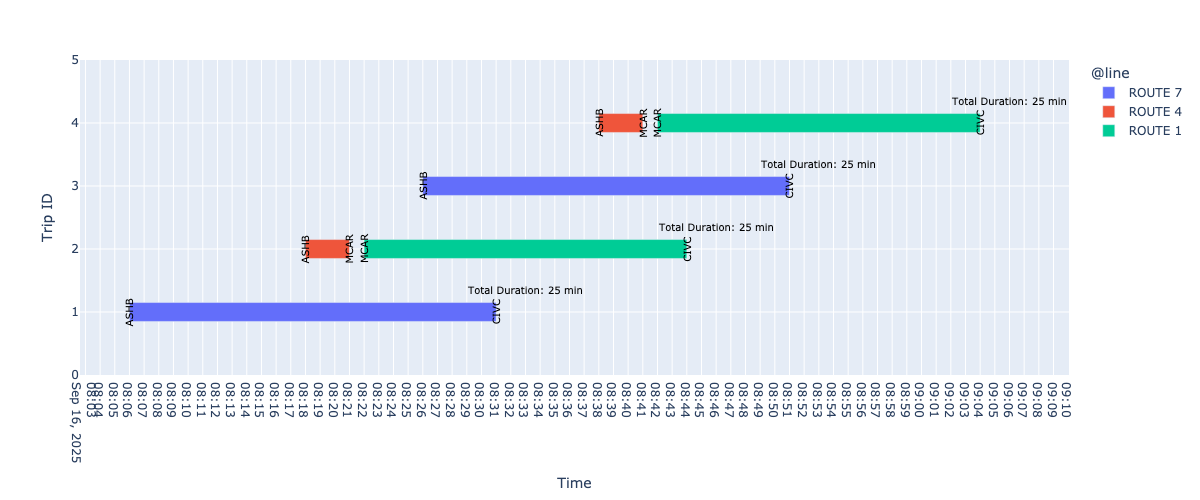

In [18]:
import plotly.express as px

import plotly.io as pio
# pio.renderers.default = "png"

png_renderer = pio.renderers["png"]
png_renderer.width = 1200
png_renderer.height = 500

# timeline
fig = px.timeline(
    legs_df,
    x_start='@origTimeMin',
    x_end='@destTimeMin',
    y='trip_id',
    color='@line',
    # hover_data=['@origin', '@destination', 'duration_min']
)

# bar thickness
fig.update_traces(width=0.3)

for i, row in legs_df.iterrows():
    # origin label
    fig.add_annotation(
        x=row['@origTimeMin'],
        y=row['trip_id'],
        text=row['@origin'],
        showarrow=False,
        xanchor='center',
        yanchor='middle',
        textangle=-90,
        font=dict(size=10, color="black")
    )
    # destination label
    fig.add_annotation(
        x=row['@destTimeMin'],
        y=row['trip_id'],
        text=row['@destination'],
        showarrow=False,
        xanchor='center',
        yanchor='middle',
        textangle=-90,
        font=dict(size=10, color="black")
    )

# total duration label
for trip_id, total_duration in legs_df.groupby('trip_id')['total_duration'].first().items():
    
    end_time = legs_df.loc[legs_df['trip_id'] == trip_id, '@destTimeMin'].max()
    
    fig.add_annotation(
        x=end_time + pd.Timedelta(minutes=2),
        y=trip_id + 0.35,
        text=f"Total Duration: {total_duration:.0f} min",
        showarrow=False,
        font=dict(size=10, color="black"),
        align="left"
    )

# gridlines
fig.update_xaxes(
    title='Time',
    showgrid=True,
    dtick=1*60*1000
)
fig.update_yaxes(title='Trip ID', showgrid=True)

fig.show()